# CS5344 Project: Evolution of Public Emotions Towards COVID-19 over Time

## Installation

In [1]:
# Packages needed
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# For data preprocessing
import spacy
import nltk
import re
from emot.emo_unicode import UNICODE_EMOJI
from emot.emo_unicode import EMOTICONS_EMO
import wordninja
import en_core_web_sm
nlp = en_core_web_sm.load()
ps = nltk.PorterStemmer()

# For data analysis
from wordcloud import WordCloud, STOPWORDS

# To follow progress
from tqdm.auto import tqdm
tqdm.pandas()

# For labeling sentiment of a tweet
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

# For training the classification model
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

# For measuring performance
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

D:\Anaconda\envs\data2text\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to C:\Users\Estelle
[nltk_data]     Zheng\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]


## Data Loading

In [2]:
# Create dataframe by loading the dataset (csv file)
column_names = ['ID', 'Location', 'Time', 'Tweet']
df = pd.read_csv('data.csv', names=column_names, error_bad_lines=False)
df = df.drop('ID', axis=1) # drop column id
df = df.astype({'Tweet':'string'})
df = df.dropna(subset=['Tweet']) # drop rows where the "Tweet" field is null
df = df.copy()
df

,Location,Time,Tweet
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1,UK,16-03-2020,advice Talk to your neighbours family to excha...
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...
3,NaN,16-03-2020,My food stock is not the only one which is emp...
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV..."
...,...,...,...
573568,NaN,20-10-2020,governor use feder tax money earmark covid19 r...
573569,NaN,20-10-2020,sinc covid19 lockdown began countri april nige...
573570,"Virginia, USA",20-10-2020,began warn januari earli march hammer trump to...
573571,"Nederland""",20-10-2020,worker countri sign petit reinstat worker mass...


In [3]:
print("Number of tweets in dataset:", len(df))

Number of tweets in dataset: 569632


### Cleaning column "Time"

In [4]:
# Look into column "Time"
print("Number of unique values of Time: ", len(df["Time"].unique()))
print("Number of NaN for Time in dataset:", df['Time'].isnull().sum()) # many NaN values in the 'Time' column
df["Time"].unique() # many values that are not dates in the 'Time' column

Number of unique values of Time:  1572
Number of NaN for Time in dataset: 106786


array(['16-03-2020',
       'March 16. Further closure or limited hours will be announced the following week',
       'Corona Go! #coronavirus https://t.co/A1lvkLHUKY\\",Extremely Positive\n4189,Auburndale',
       ..., ' orig So. Cal."', ' Scottsdale"', ' and Puerto Rico"'],
      dtype=object)

In [5]:
df = df[~df['Time'].str.contains(r'[A-Za-z]', regex=True, na=False) & df['Time'].str.contains(r'\d\d-\d\d-\d\d\d\d', regex=True, na=False)]
print("After cleaning column 'Time', number of tweets in dataset:", len(df))
print("After cleaning column 'Time', number of unique values of Time: ", len(df["Time"].unique()))
print("After cleaning column 'Time', number of NaN for Time in dataset:", df['Time'].isnull().sum())
df["Time"].unique()

After cleaning column 'Time', number of tweets in dataset: 459644
After cleaning column 'Time', number of unique values of Time:  155
After cleaning column 'Time', number of NaN for Time in dataset: 0


array(['16-03-2020', '17-03-2020', '18-03-2020', '19-03-2020',
       '20-03-2020', '21-03-2020', '22-03-2020', '23-03-2020',
       '24-03-2020', '25-03-2020', '26-03-2020', '27-03-2020',
       '28-03-2020', '29-03-2020', '30-03-2020', '31-03-2020',
       '01-04-2020', '02-04-2020', '03-04-2020', '04-04-2020',
       '05-04-2020', '06-04-2020', '07-04-2020', '08-04-2020',
       '09-04-2020', '10-04-2020', '11-04-2020', '12-04-2020',
       '13-04-2020', '14-04-2020', '19-04-2020', '22-04-2020',
       '23-04-2020', '24-04-2020', '25-04-2020', '26-04-2020',
       '27-04-2020', '28-04-2020', '29-04-2020', '30-04-2020',
       '01-05-2020', '02-05-2020', '03-05-2020', '04-05-2020',
       '05-05-2020', '06-05-2020', '07-05-2020', '08-05-2020',
       '09-05-2020', '10-05-2020', '11-05-2020', '12-05-2020',
       '13-05-2020', '14-05-2020', '15-05-2020', '16-05-2020',
       '17-05-2020', '18-05-2020', '19-05-2020', '20-05-2020',
       '22-05-2020', '23-05-2020', '24-05-2020', '25-05

## Data Preprocessing

### Preprocess tweets

In [6]:
chat_dict = {'im': "I am","ur":"You are",'atm': 'At The Moment','afaik': 'As Far as I Know','b/c': 'Because','bc': 'Because','bfn': 'Bye For Now',
                 'br': 'Best Regards','btw': 'By the Way','dm': 'Direct Message','em': 'email','fb': 'facebook','ff': 'Follow Friday','ffs': "For Fuck's Sake",
                 'fml': 'Fuk My Life','ftf': 'Face To Face','ftl': 'For The Loss','ftw': 'For The Win','fwd': 'Forward','fwiw': "For What It's Worth",
                 'ht': 'Hat Tip','hth': 'Hope That Helps','imho': 'In My Humble Opinion','imo': 'In My Opinion','irl': 'In Real Life','j/k': 'Just Kidding',
                 'li': 'LinkedIn','lmk': 'Let Me Know','lol': 'Laughing Out Loud','mt': 'Modified Tweet','nsfw': 'Not Safe For Work','oh': 'Overheard',
                 'omfg': 'Oh My Fucking God','omg': 'Oh My God','prt': 'Partial Retweet','re': 'Replies','rr': 'Re-Run', 'rt': 'Retweet','rtf': 'Read The FAQ',
                 'rtfm': 'Read The Fucking Manual','rthx': 'Thanks For The Retweet','snafu': 'Situation Normal All Fucked Up','sob': 'Son Of a Bitch',
                 'stfu': 'Shut the Fuck Up',"smh": "Shake My Head",'tmb': 'Tweet Me Back','tmi': 'Too Much Information','wtf': 'What The Fuck','ymmv': 'Your Mileage May Vary',
                 'yw': "You're Welcome", 'tl;DR': "Too Long Dind't Read", "$": "Dollar", "€": "Euro", "£": "Pound","4ao": "For Adults Only", "a.m": "Before Midday",
                 "a3": "Anytime Anywhere Anyplace","aamof": "As A Matter Of Fact","acct": "Account","adih": "Another Day In Hell","afaic": "As Far As I Am Concerned",
                 "afaict": "As Far As I Can Tell","afaik": "As Far As I Know","afair": "As Far As I Remember","afk": "Away From Keyboard","app": "Application","aymm": "Are You My Mother",
                 "approx": "Approximately","apps": "Applications","asap": "As Soon As Possible","asl": "Age, Sex, Location","atk": "At The Keyboard","ave.": "Avenue",
                 "ayor": "At Your Own Risk","b&b": "Bed And Breakfast","b+b": "Bed And Breakfast","b.c": "Before Christ","b2b": "Business To Business","b2c": "Business To Customer",
                 "b4": "Before","cf": "Compare","cu": "See You","cul8r": "See You Later","cv": "Curriculum Vitae","cwot": "Complete Waste Of Time","cya": "See You",
                 "cyt": "See You Tomorrow","dae": "Does Anyone Else","diy": "Do It Yourself","dm": "Direct Message","eg": "Example","faq": "Frequently Asked Questions",
                 "fb": "Facebook","fc": "Fingers Crossed","fig": "Figure","ft.": "Feet","ft": "Featuring","fwiw": "For What It Is Worth","fyi": "For Your Information","g9": "Genius",
                 "gg": "Good Game","gl": "Good Luck","gn": "Good Night","g.o.a.t": "Greatest Of All Time", "goat": "Greatest Of All Time","goi": "Get Over It",
                 "gps": "Global Positioning System","gyal": "Girl","ic": "I See","idc": "I Do Not Care","idk": "I Do Not Know","ie": "That Is","i.e": "That Is","ifyp": "I Feel Your Pain",
                 "ig": "Instagram","iirc": "If I Remember Correctly","ilu": "I Love You","ily": "I Love You","imho": "In My Humble Opinion","imo": "In My Opinion","imu": "I Miss You",
                 "iow": "In Other Words","irl": "In Real Life","j4f": "Just For Fun","jic": "Just In Case","jk": "Just Kidding","jsyk": "Just So You Know","l8r": "Later",
                 "lb": "Pound","lbs": "Pounds","ldr": "Long Distance Relationship","lmao": "Laugh My Ass Off","lmfao": "Laugh My Fucking Ass Off","lol": "Laughing Out Loud",
                 "ltd": "Limited","ltns": "Long Time No See","m8": "Mate","mr": "Mister","ms": "Miss","nvr": "Never","og": "Original","oic": "Oh I See","omg": "Oh My God",
                 "omw": "On My Way","p.m": "After Midday","pm": "Prime Minister","poc": "People Of Color","pov": "Point Of View","pp": "Pages","ppl": "People",
                 "srsly": "Seriously","tbh": "To Be Honest","tho": "Though","thx": "Thank You","tia": "Thanks In Advance","til": "Today I Learned","w/": "With","w/o": "Without",
                 "w8": "Wait","wassup": "What Is Up","ynk": "You Never Know","zzz": "Sleeping Bored And Tired", "sinc": "since"}

chat_dict_bis = dict([("hmmyou",""),("sry","sorry"),("inlove","in love"),("thats",""),("wanna",""),
                  ("soo","so"),("inlove","in love"),("amazingwell","amazing well"),
                  ("messagesorry","message sorry"),("½",""),
                  ("ahmazing","amazing"),("wont","will not"),("didnt","did not"),("dont","do not"),
                  ("lookin","looking"),("u","you"),("youre","you are"),("nite","night"),("isnt","is not"),
                  ("k",""),("is",""),("doesnt","does not"),("l",""),("x",""),("c",""),("ur","your"),
                  ("e",""),("yall","you all"),("he",""),("us",""),("okim","ok i am"),("jealousi","jealous"),
                  ("srry","sorry"),("itll","it will"),("vs",""),("weeknend","weekend"),("w",""),
                  ("yr","year"),("youve","you have"),("havent","have not"),("iï",""),("gonna","going to"),
                  ("gimme","give me"),("ti",""),("ta",""),("thru","through"),("th",""),("imma","i am going to"),
                  ("wasnt","was not"),("arent","are not"), ("bff","best friend forever"),("sometimesdid","sometimes did"),
                  ("waitt","wait"),("bday","birthday"),("toobut","too but"),("showerand","shower and"),
                  ("innit","is not it"),("surgury","surgery"),("soproudofyo","so proud of you"),("p",""),
                  ("couldnt","could not"),("dohforgot","forgot"),("rih","right"),("b",""),("bmovie","movie"),
                  ("pleaseyour","please your"),("tonite","tonight"),("grea","great"),("se",""),("soonso","soon so"),
                  ("gettin","getting"),("blowin","blowing"),("coz","because"),("thanks","thank"),("st",""),("rd",""),
                  ("gtta","have got to"),("gotta","have got to"),("anythingwondering","anything wondering"),
                  ("annoyedy","annoyed"),("p",""),("beatiful","beautiful"),("multitaskin","multitasking"),
                  ("nightmornin","night morning"),("thankyou","thank you"),  ("januari", "january"), ("earli", "early"),
                  ("tmwr","tomorrow"),("wordslooks","words looks"),("ima","i am going to"),("liek","like"),("mr",""),
                  ("allnighter","all nighter"),("tho","though"),("ed",""),("fyou",""),("footlong","foot long"),
                  ("placepiggy","place piggy"),("semiflaky","semi flaky"),("gona","going to"),("tmr","tomorrow"),
                  ("ppl","people"),("n",""),("dis","this"),("dun","done"),("houseee","house"),("havee","have"),
                  ("studyingwhew","studying whew"),("awwyoure","aww you are"),("softyi","softy"),
                  ("weddingyou","wedding you"),("hassnt","has not"),("lowerleft","lower left"),("anywayss","anyway"),
                  ("adoarble","adorable"),("blogyeahhhh","blog yeahhhh"),("billsim","bills i am"),("ps",""),
                  ("cheescake","cheesecake"),("morningafternoonnight","morning after noon night"),
                  ("allstudying","all studying"),("ofcoooursee","of course"),("jst","just"),("shes","she is"),
                  ("sonicswhich","sonics which"),("ouchwaited","ouch waited"),("itll","it will"),("orreply","or reply"),
                  ("somethin","something"),("fridayand","friday and"),("outta","out of"),("herenever","here never"), 
                  ("ain't","am not "),("aren't","are not"),("can't","cannot"),("can't've","cannot have"),("'cause","because"),
                  ("could've", "could have"),("couldn't", "could not"),("couldn't've", "could not have"),("didn't", "did not"),
                  ("doesn't", "does not"),("don't", "do not"),("hadn't", "had not"),("hadn't've", "had not have"),("hasn't", "has not"),
                  ("haven't", "have not"),("he'd", "he had / he would"),("he'd've", "he would have"),("he'll", "he shall / he will"),
                  ("he'll've", "he will have"),("he's", "he has / he is"),("how'd", "how did"),("how'd'y", "how do you"),
                  ("how'll", "how will"),("how's", "how is"),("i'd", "I had"),("i'd've", "I would have"),("i'll", "I will"),
                  ("i'll've", "I will have"),("i'm", "I am"),("i've", "I have"),("isn't", "is not"),("it'd", "it would"),("it'd've", "it would have"),
                  ("it'll", "it will"),("it'll've", "it will have"),("it's", "it is"),("let's", "let us"),("ma'am", "madam"),
                  ("mayn't", "may not"),("might've", "might have"),("mightn't", "might not"),("mightn't've", "might not have"),
                  ("must've", "must have"),("mustn't","must not"),("mustn't've", "must not have"),("needn't", "need not"),
                  ("needn't've", "need not have"),("o'clock", "of the clock"),("oughtn't", "ought not"),("oughtn't've", "ought not have"),
                  ("shan't", "shall not"),("sha'n't", "shall not"),("shan't've", "shall not have"),("she'd", "she would"),
                  ("she'd've", "she would have"),("she'll", "she will"),("she'll've","she will have"),("she's", "she is"),
                  ("should've", "should have"),("shouldn't","should not"),("shouldn't've", "should not have"),("so've", "so have"),
                  ("so's", "so is"),("that'd", "that had"),("that'd've","that would have"),("that's", "that is"),("there'd", "there would"),
                  ("there'd've", "there would have"),("there's", "there is"),("they'd", "they had"),("they'd've", "they would have"),
                  ("they'll", "they will"),("they'll've", "they will have"),("they're", "they are"),("they've", "they have"),
                  ("to've", "to have"),("wasn't", "was not"),("we'd", "we had / we would"),("we'd've", "we would have"),
                  ("we'll", "we will"),("we'll've", "we will have"),("we're", "we are"),("we've", "we have"),("weren't", "were not"),
                  ("what'll", "what will"),("what'll've", "what will have"),("what're", "what are"),("what's", "what is"),
                  ("what've", "what have"),("when's", "when is"),("when've", "when have"),("where'd", "where did"),("where's", "where is"),
                  ("where've", "where have"),("who'll", "who will"),("who'll've", "who will have"),("who's", "who is"),("who've", "who have"),
                  ("why's", "why is"),("why've", "why have"),("will've", "will have"),("won't", "will not"),("won't've", "will not have"),
                  ("would've", "would have"),("wouldn't", "would not"),("wouldn't've", "would not have"),("y'all", "you all"),("y'all'd", "you all would"),
                  ("y'all'd've", "you all would have"),("y'all're", "you all are"),("y'all've", "you all have"),("you'd", "you had"),
                  ("you'd've", "you would have"),("you'll", "you will"),("you'll've", "you will have"),("you're", "you are"),("you've", "you have")
                ])

ABBREV_DICT = dict([("AFAIK","As Far As I Know"),("AFK","Away From Keyboard"),("ASAP","As Soon As Possible"),
                  ("ATK","At The Keyboard"),("ATM","At The Moment"),("A3","Anytime, Anywhere, Anyplace"),
                  ("BAK","Back At Keyboard"),("BBL","Be Back Later"),("BBS","Be Back Soon"),("BFN","Bye For Now"),
                  ("B4N","Bye For Now"),("BRB","Be Right Back"),("BRT","Be Right There"),("BTW","By The Way"),
                  ("B4","Before"),("B4N","Bye For Now"),("CU","See You"),("CUL8R","See You Later"),("CYA","See You"),
                  ("FAQ","Frequently Asked Questions"),("FC","Fingers Crossed"),("FWIW","For What It's Worth"),
                  ("FYI","For Your Information"),("GAL","Get A Life"),("GG","Good Game"),("GN","Good Night"),
                  ("GMTA","Great Minds Think Alike"),("GR8","Great!"),("G9","Genius"),("IC","I See"),
                  ("ICQ","I Seek you"),("ILU","I Love You"),("IMHO","In My Honest Opinion"),("IMO","In My Opinion"),
                  ("IOW","In Other Words"),("IRL","In Real Life"),("KISS","Keep It Simple, Stupid"),("LDR","Long Distance Relationship"),
                  ("LMAO","Laugh My fuck Off"),("LOL","Laughing Out Loud"),("LTNS","Long Time No See"),("L8R","Later"),
                  ("MTE","My Thoughts Exactly"),("M8","Mate"),("NRN","No Reply Necessary"),("OIC","Oh I See"),
                  ("PITA","Pain In The fuck"),("PRT","Party"),("PRW","Parents Are Watching"),("ROFL","Rolling On The Floor Laughing"),
                  ("ROFL","Rolling On The Floor Laughing"),("ROFLOL","Rolling On The Floor Laughing Out Loud"),
                  ("ROTFLMAO","Rolling On The Floor Laughing My fuck Off"),("SK8","Skate"),("STATS","Your sex and age"),
                  ("ASL","Age, Sex, Location"),("THX","Thank You"),("THKS","thank you"),("TTFN","Ta-Ta For Now!"),
                  ("TTYL","Talk To You Later"),("U","You"),("U2","You Too"),("U4E","Yours For Ever"),
                  ("WB","Welcome Back"),("WTF","What The fuck"),("WTG","Way To Go!"),("WUF","Where Are You From?"),
                  ("WKDN","Week-End"),("W8","Wait..."),("7K","Sick Laugher"), ("FAQ", "Frequently Asked Questions"),
                ])

In [7]:
# Remove urls
def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# Remove HTML links
def remove_html(text):
    return re.sub(r'<.*?>', '', text)

# Remove mentions
def remove_mentions(text):
    text = re.sub(r'@\w+', '', text)
    return text

# Convert emojis to text
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
        text = text.replace("_", " ")
    return text

# Convert emoticons to text
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, "_".join(EMOTICONS_EMO[emot].replace(",","").replace(":","").split()))
        text = text.replace("_", " ")
    return text

# Replace hashtags by removing the # sign and split concatenated words of the hashtag
def replace_hashtags(text):
    tweet_tokens = [token for token in text.split(" ") if token != '']
    final_tweet_tokens = []
    for i in range(len(tweet_tokens)):
        if tweet_tokens[i].startswith("#"):
            hashtag = re.findall(r"[A-Za-z's]+|[A-Za-z]+|[0-9]+", tweet_tokens[i][1:])
            for piece in hashtag:
                final_tweet_tokens += wordninja.split(piece)
        else:
            final_tweet_tokens.append(tweet_tokens[i])

    return ' '.join(final_tweet_tokens)

# Replace texts due to html conversion like '&amp;' with 'and'
def replace_html(text):
    text = re.sub(r'&amp;', ' and ', text)
    text = re.sub(r"Â'", "'", text)
    text = re.sub(r"\x92", "'", text)
    text = re.sub(r'Â"', '', text)
    text = re.sub(r'\x93', '', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r'"', '', text)
    return text

# Replace incorrect and abbreviated words, notably slang words
def replace_words(text):
    tokens = text.split()
    for i, token in enumerate(tokens):
        for key1 in chat_dict:
            if token.lower() == key1:
                tokens[i] = chat_dict[key1]
        for key2 in ABBREV_DICT:
            if token.upper() == key2:
                tokens[i] = ABBREV_DICT[key2]
        for key3 in chat_dict_bis:
            if token.lower() == key3:
                tokens[i] = chat_dict_bis[key3]
    return ' '.join(tokens)

# Remove non-ascii words
def remove_non_ascii(text):
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    return text

# Remove trailing whitespace
def remove_trailing_whitespace(text):
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Convert to lowercase
def lowercase(text):
    return text.lower()

# Preprocess the text given and return the preprocessed text
def preprocessing_for_bert(text):
    text = remove_urls(text)
    text = remove_html(text)
    text = remove_mentions(text)
    text = convert_emojis(text)
    text = convert_emoticons(text)
    text = replace_hashtags(text)
    text = replace_html(text)
    text = replace_words(text)
    text = remove_non_ascii(text)
    text = remove_trailing_whitespace(text)
    text = lowercase(text)
    text = re.sub(r'\sovid', ' covid', text)

    return text

In [8]:
# Apply preprocessing to tweets
df['Preprocessed_tweet'] = df['Tweet'].progress_apply(preprocessing_for_bert)
df.head(10)

100%|█████████████████████████████████████████████████████████████████████████| 459644/459644 [13:04<00:00, 586.18it/s]
D:\Anaconda\envs\data2text\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Location,Time,Tweet,Preprocessed_tweet
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,and and
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,advice talk to your neighbours family to excha...
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,coronavirus australia: woolworths to give elde...
3,NaN,16-03-2020,My food stock is not the only one which is emp...,my food stock not the only one which empty...
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...","me, ready to go at supermarket during the covi..."
5,"ÜT: 36.319708,-82.363649",16-03-2020,As news of the regions first confirmed COVID-...,as news of the region's first confirmed covid-...
6,"35.926541,-78.753267",16-03-2020,\Cashier at grocery store was sharing his insi...,cashier at grocery store was sharing his insig...
7,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,was at the supermarket today. did not buy toil...
8,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,due to covid-19 our retail store and classroom...
9,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...","for corona prevention,we should stop to buy th..."


### Add column "Sentiment" to the dataframe to create labels and use supervised learning

In [9]:
def sentiment(x):
    overall_sentiment = ''
    if x['compound'] >= 0.1 :
        overall_sentiment = "Positive"

    elif x['compound'] <= - 0.1 :
        overall_sentiment = "Negative"

    else :
        overall_sentiment = "Neutral"
    return overall_sentiment

sia = SentimentIntensityAnalyzer()
df['Sentiment'] = df['Preprocessed_tweet'].progress_apply(lambda tweet: sentiment(sia.polarity_scores(tweet)))

100%|███████████████████████████████████████████████████████████████████████| 459644/459644 [00:36<00:00, 12652.62it/s]
D:\Anaconda\envs\data2text\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
# Distribution of labels
df['Sentiment'].value_counts()

Neutral     187517
Positive    139608
Negative    132519
Name: Sentiment, dtype: int64

## Data Analysis

In [11]:
# Average number of words in tweets (total and w.r.t. each sentiment)
print("Average number of words in tweets: ", df['Preprocessed_tweet'].str.split().map(lambda x: len(x)).mean())
print("Average number of words in negative tweets: ", df[df["Sentiment"] == 'Negative']['Preprocessed_tweet'].str.split().map(lambda x: len(x)).mean())
print("Average number of words in neutral tweets: ", df[df["Sentiment"] == 'Neutral']['Preprocessed_tweet'].str.split().map(lambda x: len(x)).mean())
print("Average number of words in positive tweets: ", df[df["Sentiment"] == 'Positive']['Preprocessed_tweet'].str.split().map(lambda x: len(x)).mean())

Average number of words in tweets:  12.440956479362288
Average number of words in negative tweets:  13.425629532368943
Average number of words in neutral tweets:  10.579168822026803
Average number of words in positive tweets:  14.006976677554295


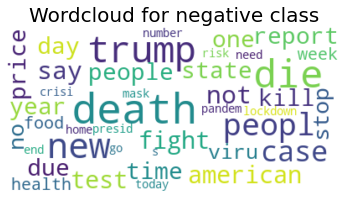

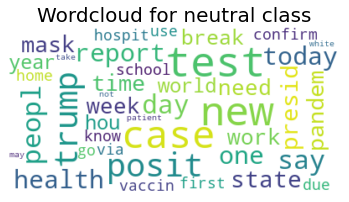

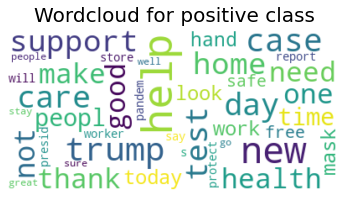

In [12]:
stopwords = set(STOPWORDS)
words_to_keep = ["no","nor","not"] # Remove negation words from remove from stopwords list
stopwords = [elem for elem in stopwords if not elem in words_to_keep]
stopwords.extend(["covid","covid19","covid-","19","coronavirus","coronaviru"]) # Other stopwords to remove (words like covid-19)

# Word cloud for Negative class
wordcloud_neg = WordCloud(stopwords=stopwords, max_font_size=50, max_words=40, collocations=False, background_color='white').generate(" ".join(review for review in df[df.Sentiment=='Negative']['Preprocessed_tweet']))
plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Wordcloud for negative class", fontsize=20)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.show()
print()

# Word cloud for Neutral class
wordcloud_neut = WordCloud(stopwords=stopwords, max_font_size=50, max_words=40, collocations=False, background_color='white').generate(" ".join(review for review in df[df.Sentiment=='Neutral']['Preprocessed_tweet']))
plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Wordcloud for neutral class", fontsize=20)
plt.imshow(wordcloud_neut, interpolation="bilinear")
plt.show()
print()

# Word cloud for Positive class
wordcloud_pos = WordCloud(stopwords=stopwords, max_font_size=50, max_words=40,collocations=False, background_color='white').generate(" ".join(review for review in df[df.Sentiment=='Positive']['Preprocessed_tweet']))
plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Wordcloud for positive class", fontsize=20)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.show()

## Training/Test process

### Training the model RoBERTa

In [13]:
# Convert labels to 0/1/2 because BERT cannot have negative labels
target_conversion = {
    'Neutral': 1, 
    'Positive': 2,
    'Negative': 0 
}
df['Target'] = df['Sentiment'].map(target_conversion) 
df.head(10)

D:\Anaconda\envs\data2text\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Location,Time,Tweet,Preprocessed_tweet,Sentiment,Target
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,and and,Neutral,1
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,advice talk to your neighbours family to excha...,Positive,2
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,coronavirus australia: woolworths to give elde...,Positive,2
3,NaN,16-03-2020,My food stock is not the only one which is emp...,my food stock not the only one which empty...,Neutral,1
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...","me, ready to go at supermarket during the covi...",Positive,2
5,"ÜT: 36.319708,-82.363649",16-03-2020,As news of the regions first confirmed COVID-...,as news of the region's first confirmed covid-...,Positive,2
6,"35.926541,-78.753267",16-03-2020,\Cashier at grocery store was sharing his insi...,cashier at grocery store was sharing his insig...,Positive,2
7,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,was at the supermarket today. did not buy toil...,Negative,0
8,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,due to covid-19 our retail store and classroom...,Positive,2
9,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...","for corona prevention,we should stop to buy th...",Negative,0


In [14]:
# Create classifier's dataset (X: tweets, y: sentiment label)
X = df['Preprocessed_tweet'].values
y = df['Target'].values

# Split train/eval/test sets
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.2, stratify=y_training, random_state=123)

# Convert labels to one hot encoded versions
y_train = tf.one_hot(y_train, 3).numpy()
y_val = tf.one_hot(y_val, 3).numpy()
y_test = tf.one_hot(y_test, 3).numpy()

In [18]:
# Import the tokenizer and use it on the train/eval/test datasets
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
def encode_data(dataset):
    input_ids_list = []
    attention_masks_list = []
    for i in range(len(dataset)):
        encoded_example_i = tokenizer.encode_plus(
                              dataset[i],
                              add_special_tokens=True,
                              max_length=290,
                              padding='max_length',
                              return_attention_mask=True, 
                              truncation=True
                          )
        input_ids_list.append(np.array(encoded_example_i['input_ids']))
        attention_masks_list.append(np.array(encoded_example_i['attention_mask']))
    return np.array(input_ids_list), np.array(attention_masks_list)

train_input_ids_list, train_attention_masks_list = encode_data(X_train)
val_input_ids_list, val_attention_masks_list = encode_data(X_val)
test_input_ids_list, test_attention_masks_list = encode_data(X_test)

In [19]:
# Model initialization
model_base = TFRobertaModel.from_pretrained('roberta-base')
input_ids = tf.keras.Input(shape=(290,), dtype='int32')
attention_masks = tf.keras.Input(shape=(290,), dtype='int32')
output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(model_base([input_ids,attention_masks])[1])
model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

# Choose Adam optimizer, categorical cross entropy loss and 'accuracy' metric
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-08)
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer, loss=loss, metrics=metric)
model.summary()


Downloading:   0%|                                                                          | 0.00/657M [00:00<?, ?B/s]
Downloading:   0%|▏                                                                | 1.40M/657M [00:00<00:53, 12.2MB/s]
Downloading:   0%|▎                                                                | 2.66M/657M [00:00<00:53, 12.2MB/s]
Downloading:   1%|▍                                                                | 3.88M/657M [00:00<01:04, 10.1MB/s]
Downloading:   1%|▍                                                                | 4.93M/657M [00:00<01:04, 10.1MB/s]
Downloading:   1%|▌                                                                | 6.20M/657M [00:00<01:02, 10.5MB/s]
Downloading:   1%|▋                                                                | 7.46M/657M [00:00<01:00, 10.7MB/s]
Downloading:   1%|▊                                                                | 8.82M/657M [00:00<00:58, 11.1MB/s]
Downloading:   2%|▉                    

Downloading:  12%|███████▍                                                         | 75.7M/657M [00:10<00:47, 12.2MB/s]
Downloading:  12%|███████▌                                                         | 76.9M/657M [00:10<00:47, 12.2MB/s]
Downloading:  12%|███████▋                                                         | 78.2M/657M [00:10<00:47, 12.3MB/s]
Downloading:  12%|███████▉                                                         | 79.7M/657M [00:11<00:46, 12.3MB/s]
Downloading:  12%|███████▉                                                         | 80.9M/657M [00:11<01:02, 9.20MB/s]
Downloading:  12%|████████                                                         | 81.9M/657M [00:11<01:33, 6.18MB/s]
Downloading:  13%|████████▏                                                        | 82.7M/657M [00:11<02:05, 4.58MB/s]
Downloading:  13%|████████▎                                                        | 83.9M/657M [00:12<01:42, 5.59MB/s]
Downloading:  13%|████████▍             

Downloading:  23%|███████████████▏                                                  | 151M/657M [00:20<01:51, 4.54MB/s]
Downloading:  23%|███████████████▏                                                  | 152M/657M [00:20<02:57, 2.84MB/s]
Downloading:  23%|███████████████▎                                                  | 152M/657M [00:20<02:17, 3.67MB/s]
Downloading:  23%|███████████████▍                                                  | 154M/657M [00:21<01:39, 5.09MB/s]
Downloading:  23%|███████████████▍                                                  | 154M/657M [00:21<01:34, 5.33MB/s]
Downloading:  24%|███████████████▌                                                  | 155M/657M [00:21<01:14, 6.77MB/s]
Downloading:  24%|███████████████▋                                                  | 156M/657M [00:21<01:11, 6.97MB/s]
Downloading:  24%|███████████████▊                                                  | 158M/657M [00:21<00:59, 8.47MB/s]
Downloading:  24%|███████████████▉      

Downloading:  35%|██████████████████████▉                                           | 228M/657M [00:29<00:46, 9.16MB/s]
Downloading:  35%|███████████████████████                                           | 229M/657M [00:30<00:47, 8.97MB/s]
Downloading:  35%|███████████████████████▏                                          | 231M/657M [00:30<00:43, 9.71MB/s]
Downloading:  35%|███████████████████████▎                                          | 232M/657M [00:30<00:40, 10.4MB/s]
Downloading:  35%|███████████████████████▍                                          | 233M/657M [00:30<00:38, 11.1MB/s]
Downloading:  36%|███████████████████████▌                                          | 234M/657M [00:30<00:36, 11.6MB/s]
Downloading:  36%|███████████████████████▋                                          | 236M/657M [00:30<00:35, 11.9MB/s]
Downloading:  36%|███████████████████████▊                                          | 237M/657M [00:30<00:46, 9.09MB/s]
Downloading:  36%|██████████████████████

Downloading:  47%|██████████████████████████████▉                                   | 308M/657M [00:38<00:55, 6.26MB/s]
Downloading:  47%|███████████████████████████████                                   | 309M/657M [00:38<00:49, 7.05MB/s]
Downloading:  47%|███████████████████████████████▏                                  | 310M/657M [00:39<00:42, 8.22MB/s]
Downloading:  47%|███████████████████████████████▎                                  | 312M/657M [00:39<00:38, 8.92MB/s]
Downloading:  48%|███████████████████████████████▍                                  | 313M/657M [00:39<00:35, 9.77MB/s]
Downloading:  48%|███████████████████████████████▌                                  | 314M/657M [00:39<00:33, 10.3MB/s]
Downloading:  48%|███████████████████████████████▋                                  | 315M/657M [00:39<00:31, 10.9MB/s]
Downloading:  48%|███████████████████████████████▊                                  | 317M/657M [00:39<00:30, 11.2MB/s]
Downloading:  48%|██████████████████████

Downloading:  59%|██████████████████████████████████████▉                           | 388M/657M [00:47<00:30, 8.93MB/s]
Downloading:  59%|███████████████████████████████████████                           | 389M/657M [00:47<01:01, 4.39MB/s]
Downloading:  59%|███████████████████████████████████████                           | 389M/657M [00:48<01:23, 3.23MB/s]
Downloading:  59%|███████████████████████████████████████▏                          | 390M/657M [00:48<01:17, 3.47MB/s]
Downloading:  59%|███████████████████████████████████████▏                          | 390M/657M [00:48<01:11, 3.74MB/s]
Downloading:  59%|███████████████████████████████████████▎                          | 391M/657M [00:48<01:06, 3.99MB/s]
Downloading:  60%|███████████████████████████████████████▎                          | 392M/657M [00:48<01:12, 3.65MB/s]
Downloading:  60%|███████████████████████████████████████▎                          | 392M/657M [00:48<01:06, 4.00MB/s]
Downloading:  60%|██████████████████████

Downloading:  70%|██████████████████████████████████████████████▎                   | 461M/657M [00:59<01:43, 1.89MB/s]
Downloading:  70%|██████████████████████████████████████████████▍                   | 462M/657M [01:00<01:15, 2.60MB/s]
Downloading:  70%|██████████████████████████████████████████████▌                   | 463M/657M [01:00<01:05, 2.95MB/s]
Downloading:  71%|██████████████████████████████████████████████▋                   | 464M/657M [01:00<00:51, 3.77MB/s]
Downloading:  71%|██████████████████████████████████████████████▊                   | 466M/657M [01:00<00:38, 4.98MB/s]
Downloading:  71%|██████████████████████████████████████████████▉                   | 467M/657M [01:00<00:30, 6.22MB/s]
Downloading:  71%|███████████████████████████████████████████████                   | 469M/657M [01:00<00:28, 6.66MB/s]
Downloading:  71%|███████████████████████████████████████████████▏                  | 470M/657M [01:00<00:25, 7.40MB/s]
Downloading:  72%|██████████████████████

Downloading:  82%|██████████████████████████████████████████████████████            | 538M/657M [01:09<00:24, 4.87MB/s]
Downloading:  82%|██████████████████████████████████████████████████████            | 539M/657M [01:09<00:24, 4.78MB/s]
Downloading:  82%|██████████████████████████████████████████████████████▏           | 540M/657M [01:09<00:19, 6.06MB/s]
Downloading:  82%|██████████████████████████████████████████████████████▎           | 541M/657M [01:09<00:15, 7.46MB/s]
Downloading:  82%|██████████████████████████████████████████████████████▍           | 542M/657M [01:09<00:16, 7.00MB/s]
Downloading:  83%|██████████████████████████████████████████████████████▌           | 543M/657M [01:10<00:23, 4.84MB/s]
Downloading:  83%|██████████████████████████████████████████████████████▌           | 544M/657M [01:10<00:26, 4.29MB/s]
Downloading:  83%|██████████████████████████████████████████████████████▋           | 544M/657M [01:10<00:27, 4.09MB/s]
Downloading:  83%|██████████████████████

Downloading:  93%|█████████████████████████████████████████████████████████████▍    | 613M/657M [01:19<00:06, 7.01MB/s]
Downloading:  93%|█████████████████████████████████████████████████████████████▌    | 614M/657M [01:19<00:05, 7.82MB/s]
Downloading:  94%|█████████████████████████████████████████████████████████████▋    | 615M/657M [01:19<00:04, 8.93MB/s]
Downloading:  94%|█████████████████████████████████████████████████████████████▊    | 616M/657M [01:20<00:04, 9.45MB/s]
Downloading:  94%|█████████████████████████████████████████████████████████████▉    | 617M/657M [01:20<00:04, 8.34MB/s]
Downloading:  94%|██████████████████████████████████████████████████████████████    | 618M/657M [01:20<00:04, 8.77MB/s]
Downloading:  94%|██████████████████████████████████████████████████████████████▏   | 619M/657M [01:20<00:05, 6.61MB/s]
Downloading:  94%|██████████████████████████████████████████████████████████████▎   | 621M/657M [01:20<00:04, 7.72MB/s]
Downloading:  95%|██████████████████████

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 290)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 290)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 290,                                           

In [23]:
# Train the model
history = model.fit([train_input_ids_list, train_attention_masks_list], y_train, validation_data=([val_input_ids_list, val_attention_masks_list], y_val), epochs=1, batch_size=4)

64350/64350 [==============================] - 14211s 221ms/step - loss: 0.1697 - accuracy: 0.9425 - val_loss: 0.1025 - val_accuracy: 0.9632


### Inference on test dataset

In [24]:
# Make predictions on test dataset
y_pred = model.predict([test_input_ids_list, test_attention_masks_list])

4310/4310 [==============================] - 1858s 431ms/step


## Results analysis

Text(0.5, 1.0, 'Confusion Matrix for RoBERTa model')

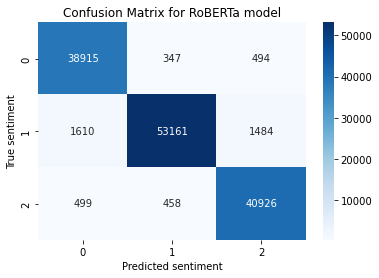

In [25]:
# Plot confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
ax = plt.subplot()
sns.heatmap(conf_matrix, annot= True, cmap='Blues', fmt="g")
ax.set_ylabel('True sentiment')
ax.set_xlabel('Predicted sentiment')
ax.set_title('Confusion Matrix for RoBERTa model')

In [26]:
print("Classification Report for RoBERTa model")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=['Negative', 'Neutral', 'Positive']))

Classification Report for RoBERTa model
              precision    recall  f1-score   support

    Negative       0.95      0.98      0.96     39756
     Neutral       0.99      0.95      0.96     56255
    Positive       0.95      0.98      0.97     41883

    accuracy                           0.96    137894
   macro avg       0.96      0.97      0.96    137894
weighted avg       0.97      0.96      0.96    137894



#### Explanability

In [37]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers_interpret import MultiLabelClassificationExplainer

roberta_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
roberta_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

Downloading: 100%|██████████████████████████████████████████████████████████████████| 499M/499M [00:49<00:00, 10.2MB/s]


In [38]:
cls_explainer = MultiLabelClassificationExplainer(roberta_model, roberta_tokenizer)

# for a negative sentiment
word_attributions_neg = cls_explainer("I hate covid 19, I cannot stand another lockdown.")
# To see the raw numeric attributions
word_attributions_neg

{'LABEL_0': [('<s>', 0.0),
  ('I', 0.16734512309389396),
  ('hate', 0.9787259216670218),
  ('cov', 0.001353577062188058),
  ('id', -0.05654719695298455),
  ('19', 0.010830124956884627),
  (',', 0.00802481896506599),
  ('I', 0.05652736110627806),
  ('cannot', 0.07388056999770666),
  ('stand', 0.004310880267008267),
  ('another', 0.007362538564895175),
  ('lockdown', 0.026805377843452556),
  ('.', -0.028225055599447595),
  ('', -0.021642993533188156),
  ('</s>', 0.0)],
 'LABEL_1': [('<s>', 0.0),
  ('I', -0.05451860110903898),
  ('hate', -0.9859249084495219),
  ('cov', 0.00605776888391401),
  ('id', 0.061337330330100276),
  ('19', -0.004899968353651094),
  (',', -0.011285935578248057),
  ('I', -0.05801197060477996),
  ('cannot', -0.08416998585449555),
  ('stand', -0.015062481297333927),
  ('another', -0.006310438799349893),
  ('lockdown', -0.025699345978185448),
  ('.', 0.05430760071774982),
  ('', 0.08187187082267162),
  ('</s>', 0.0)],
 'LABEL_2': [('<s>', 0.0),
  ('I', -0.7522941150954

In [39]:
# which class was predicted
cls_explainer.predicted_class_name

'LABEL_0'

In [40]:
cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.97),LABEL_0,1.23,"#s I hate cov id 19 , I cannot stand another lockdown . #/s"
n/a,(0.03),LABEL_1,-1.04,"#s I hate cov id 19 , I cannot stand another lockdown . #/s"
n/a,(0.01),LABEL_2,-1.81,"#s I hate cov id 19 , I cannot stand another lockdown . #/s"


n/a,Prediction Score,Attribution Label,Attribution Score,Word Importance
n/a,(0.97),LABEL_0,1.23,"#s I hate cov id 19 , I cannot stand another lockdown . #/s"
n/a,(0.03),LABEL_1,-1.04,"#s I hate cov id 19 , I cannot stand another lockdown . #/s"
n/a,(0.01),LABEL_2,-1.81,"#s I hate cov id 19 , I cannot stand another lockdown . #/s"


In [41]:
# for a positive sentiment
word_attributions_pos = cls_explainer("Thanks to COVID, many people reconnected to themselves and discovered new hobbies.")
cls_explainer.predicted_class_name

'LABEL_2'

In [42]:
cls_explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.00),LABEL_0,-3.40,"#s Thanks to CO VID , many people reconnect ed to themselves and discovered new hobbies . #/s"
n/a,(0.04),LABEL_1,-2.53,"#s Thanks to CO VID , many people reconnect ed to themselves and discovered new hobbies . #/s"
n/a,(0.96),LABEL_2,3.03,"#s Thanks to CO VID , many people reconnect ed to themselves and discovered new hobbies . #/s"


n/a,Prediction Score,Attribution Label,Attribution Score,Word Importance
n/a,(0.00),LABEL_0,-3.40,"#s Thanks to CO VID , many people reconnect ed to themselves and discovered new hobbies . #/s"
n/a,(0.04),LABEL_1,-2.53,"#s Thanks to CO VID , many people reconnect ed to themselves and discovered new hobbies . #/s"
n/a,(0.96),LABEL_2,3.03,"#s Thanks to CO VID , many people reconnect ed to themselves and discovered new hobbies . #/s"
